In [40]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from math import sqrt



In [ ]:
def carregar_dados(caminho):
    dados = pd.read_csv(caminho)
    return dados

def tratar_dados(dados):
    dados_numericos = dados.select_dtypes(include=[np.number])
    dados[dados_numericos.columns] = dados_numericos.fillna(dados_numericos.mean())

    features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
    target = 'Machine failure'

    X = dados[features].values
    y = dados[target].values

    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)
    X_normalizado = (X - X_mean) / X_std

    return X_normalizado, y

def dividir_dados_temporal(X, y):
    divisao = int(len(X) * 0.8)
    X_treino, X_teste = X[:divisao], X[divisao:]
    y_treino, y_teste = y[:divisao], y[divisao:]

    X_treino = X_treino.reshape((X_treino.shape[0], X_treino.shape[1], 1))
    X_teste = X_teste.reshape((X_teste.shape[0], X_teste.shape[1], 1))

    return X_treino, X_teste, y_treino, y_teste

def aumentar_dados(X, y):
    # Aumento de dados simples: replicar exemplos da classe minoritária
    class_counts = np.bincount(y)
    majority_class = np.argmax(class_counts)
    minority_class = 1 - majority_class
    
    X_minority = X[y == minority_class]
    y_minority = y[y == minority_class]
    
    n_to_add = class_counts[majority_class] - class_counts[minority_class]
    indices_to_add = np.random.choice(len(X_minority), n_to_add)
    
    X_res = np.concatenate([X, X_minority[indices_to_add]])
    y_res = np.concatenate([y, y_minority[indices_to_add]])
    
    return X_res, y_res

In [42]:
def criar_modelo(input_shape):
    modelo = Sequential()
    modelo.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape))
    modelo.add(BatchNormalization())
    modelo.add(Dropout(0.3))
    modelo.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    modelo.add(BatchNormalization())
    modelo.add(Dropout(0.3))
    modelo.add(Flatten())
    modelo.add(Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    modelo.add(BatchNormalization())
    modelo.add(Dropout(0.2))
    modelo.add(Dense(1, activation='sigmoid'))
    modelo.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return modelo

def avaliar_modelo(y_teste, y_predito):
    mae = np.mean(np.abs(y_teste - y_predito))
    mse = np.mean((y_teste - y_predito) ** 2)
    rmse = sqrt(mse)

    y_teste_nonzero = np.where(y_teste == 0, np.finfo(float).eps, y_teste)
    mape = np.mean(np.abs((y_teste - y_predito) / y_teste_nonzero)) * 100

    precision = precision_score(y_teste, y_predito)
    recall = recall_score(y_teste, y_predito)
    f1 = f1_score(y_teste, y_predito)

    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')


In [43]:
def plotar_matriz_confusao(y_teste, y_predito):
    cm = confusion_matrix(y_teste, y_predito)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Failure', 'Failure'])
    disp.plot(cmap='Blues')
    plt.title('Matriz de Confusão')
    plt.show()

def plotar_curva_roc(y_teste, y_probabilidades):
    fpr, tpr, _ = roc_curve(y_teste, y_probabilidades)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.show()

def plotar_metricas(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
    plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
    plt.title('Acurácia de Treinamento e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda de Treinamento')
    plt.plot(history.history['val_loss'], label='Perda de Validação')
    plt.title('Perda de Treinamento e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.show()

c:\Users\welli\anaconda3\envs\finaiti\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
385/385 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7310 - loss: 1.3158 - val_accuracy: 0.4341 - val_loss: 1.5651 - learning_rate: 1.0000e-04
Epoch 2/1000
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8359 - loss: 1.0395 - val_accuracy: 0.8435 - val_loss: 0.9530 - learning_rate: 1.0000e-04
Epoch 3/1000
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8550 - loss: 0.8970 - val_accuracy: 0.8532 - val_loss: 0.8550 - learning_rate: 1.0000e-04
Epoch 4/1000
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8672 - loss: 0.7992 - val_accuracy: 0.8708 - val_loss: 0.7519 - learning_rate: 1.0000e-04
Epoch 5/1000
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8803 - loss: 0.7142 - val_accuracy: 0.8653 - val_loss: 0.7018 - learning_rate: 1.0000e-04
Epoch 6/1000
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8798 - loss: 0.6510 - val_accuracy: 0.8773 - val_loss: 0.6388 - learning_rate: 1.0000e-04
Epoch 7/1000
385/385 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/st

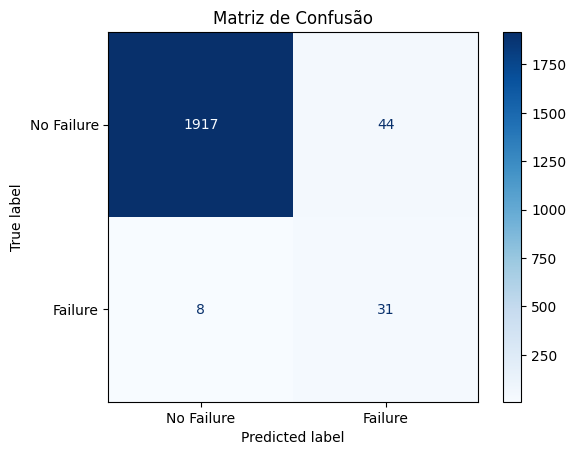

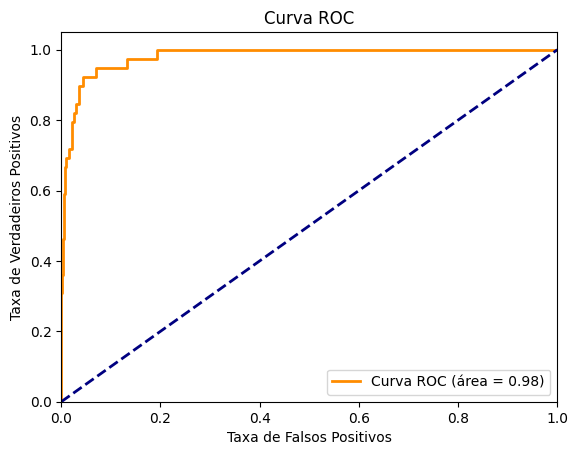

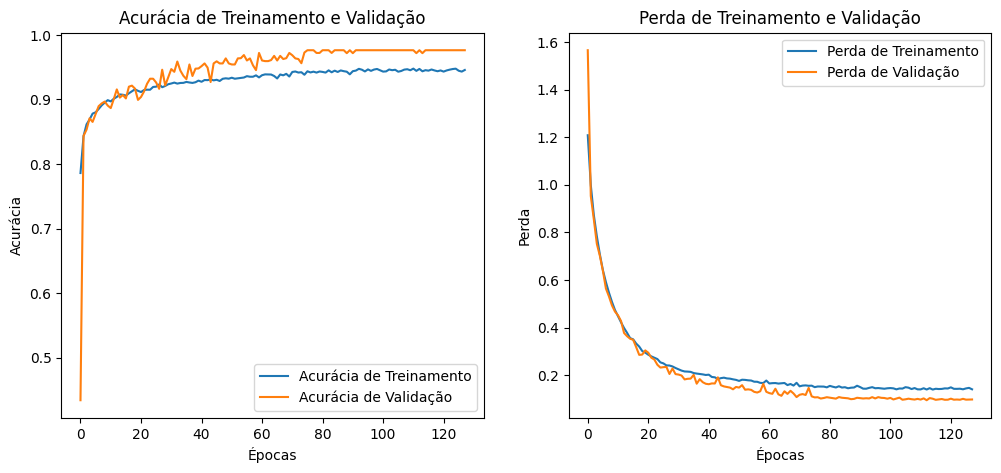

In [44]:
def main():
    caminho = 'ai4i2020.csv'
    dados = carregar_dados(caminho)

    X, y = tratar_dados(dados)
    X_treino, X_teste, y_treino, y_teste = dividir_dados_temporal(X, y)

    X_treino, y_treino = aumentar_dados(X_treino, y_treino)

    modelo = criar_modelo((X_treino.shape[1], 1))
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

    history = modelo.fit(X_treino, y_treino, epochs=1000, validation_split=0.2, callbacks=[early_stopping, reduce_lr, model_checkpoint], verbose=1)

    acuracia_treinamento = history.history['accuracy'][-1]
    acuracia_validacao = history.history['val_accuracy'][-1]
    perda_treinamento = history.history['loss'][-1]
    perda_validacao = history.history['val_loss'][-1]
    taxa_aprendizado = modelo.optimizer.learning_rate.numpy()

    print(f"Acurácia de Treinamento: {acuracia_treinamento}")
    print(f"Acurácia de Validação: {acuracia_validacao}")
    print(f"Perda de Treinamento: {perda_treinamento}")
    print(f"Perda de Validação: {perda_validacao}")
    print(f"Taxa de Aprendizado: {taxa_aprendizado}")

    y_probabilidades = modelo.predict(X_teste).flatten()
    y_predito = (y_probabilidades > 0.5).astype(int)

    avaliar_modelo(y_teste, y_predito)

    plotar_matriz_confusao(y_teste, y_predito)
    plotar_curva_roc(y_teste, y_probabilidades)
    plotar_metricas(history)

if __name__ == "__main__":
    main()